In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import cv2

# Define the GNN Model
class ClothGNN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ClothGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Generate Cloth Data
def generate_cloth_data(num_points=30):
    points = np.array([[i, j, 0] for i in range(num_points) for j in range(num_points)], dtype=np.float32)
    edges = []
    for i in range(num_points):
        for j in range(num_points):
            if i < num_points - 1:
                edges.append([i * num_points + j, (i + 1) * num_points + j])
                edges.append([(i + 1) * num_points + j, i * num_points + j])
            if j < num_points - 1:
                edges.append([i * num_points + j, i * num_points + j + 1])
                edges.append([i * num_points + j + 1, i * num_points + j])
    edges = np.array(edges, dtype=np.int64).T
    return points, edges

points, edges = generate_cloth_data()
x = torch.tensor(points, dtype=torch.float)
edge_index = torch.tensor(edges, dtype=torch.long)
data = Data(x=x, edge_index=edge_index)

# Identify the indices of the fixed points (top-left and top-right corners)
fixed_points_indices = [0, 29]

# Initialize the model, optimizer, and loss function
model = ClothGNN(in_channels=3, out_channels=3)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define the new bending loss function
def bending_loss_edge_length(output, edge_index, initial_lengths):
    current_lengths = torch.norm(output[edge_index[0]] - output[edge_index[1]], dim=1)
    deviation = torch.abs(current_lengths - initial_lengths)
    loss = torch.sum(deviation)
    return loss / edge_index.size(1)

initial_lengths = torch.norm(x[edge_index[0]] - x[edge_index[1]], dim=1)

# Placeholder for other loss functions
def collision_loss(output, min_dist=1.0):
    dist = torch.cdist(output, output, p=2)
    loss = torch.clamp(min_dist - dist, min=0)
    return loss.mean()

def inertia_loss(output, prev_output, velocity, dt=0.1):
    velocity = (output - prev_output) / dt
    expected_pos = prev_output + velocity * dt
    return nn.MSELoss()(output, expected_pos)

def gravity_loss(output, gravity_strength=9.81):
    return gravity_strength * output[:, 1].mean()

def wind_force(output, wind_strength=0.1):
    wind_direction = torch.tensor([0.0, 1.0, 0.0], dtype=torch.float)
    return wind_strength * (output @ wind_direction).mean()

# Cylinder parameters
cylinder_radius = torch.tensor(5.0)
cylinder_height = torch.tensor(30.0)
cylinder_speed = torch.tensor(0.1)
cylinder_center = torch.tensor([15.0, 0.0, 15.0])  # Initial center position
friction_coefficient = torch.tensor(0.5)
angular_velocity = torch.tensor(0.1)

# Function to handle cloth-cylinder interaction
def cylinder_collision_response(output, cylinder_center, cylinder_radius, friction_coefficient, angular_velocity, dt=0.1):
    d = torch.sqrt((output[:, 0] - cylinder_center[0]) ** 2 + (output[:, 2] - cylinder_center[2]) ** 2)
    inside_cylinder = d < cylinder_radius
    response_positions = output.clone()
    response_positions[inside_cylinder, 0] = cylinder_center[0] + (output[inside_cylinder, 0] - cylinder_center[0]) / d[inside_cylinder] * cylinder_radius
    response_positions[inside_cylinder, 2] = cylinder_center[2] + (output[inside_cylinder, 2] - cylinder_center[2]) / d[inside_cylinder] * cylinder_radius
    
    # Calculate tangential velocity of the cylinder
    v_cylinder = torch.zeros_like(output)
    v_cylinder[:, 0] = -cylinder_radius * angular_velocity * torch.sin(angular_velocity * dt)
    v_cylinder[:, 2] = cylinder_radius * angular_velocity * torch.cos(angular_velocity * dt)

    # Calculate relative velocity and apply friction force
    v_vertex = (response_positions - output) / dt
    v_rel = v_vertex - v_cylinder
    friction_force = -friction_coefficient * v_rel * dt
    response_positions[inside_cylinder] += friction_force[inside_cylinder]
    
    return response_positions


# Define the training function
prev_output = data.x.clone()
velocity = torch.zeros_like(data.x)

def train(data, fixed_points_indices, initial_lengths, bending_coefficient, wind_direction, cylinder_radius, cylinder_speed, friction_coefficient, angular_velocity, dt, epochs=100):
    global prev_output, velocity
    model.train()
    frames = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
         # Update cylinder center position
        cylinder_center[0] = cylinder_center[0] + cylinder_speed * torch.cos(cylinder_speed * epoch)
        cylinder_center[2] = cylinder_center[2] + cylinder_speed * torch.sin(cylinder_speed * epoch)

        # Apply collision response with the moving cylinder and friction force
        out = cylinder_collision_response(out, cylinder_center, cylinder_radius, friction_coefficient, angular_velocity, dt)

        
        # Keep the positions of fixed points constant
        out = out.clone()
        out[fixed_points_indices] = data.x[fixed_points_indices]

        # Compute losses
        coll_loss = collision_loss(out)
        inert_loss = inertia_loss(out, prev_output, velocity)
        grav_loss = gravity_loss(out)
        bend_loss = bending_loss_edge_length(out, data.edge_index, initial_lengths)
        wind_loss = wind_force(out)

        # Ensure all losses are positive
        coll_loss = torch.abs(coll_loss)
        inert_loss = torch.abs(inert_loss)
        grav_loss = torch.abs(grav_loss)
        bend_loss = torch.abs(bend_loss)
        wind_loss = torch.abs(wind_loss)

        # Aggregate all losses into a single scalar value
        loss = coll_loss + inert_loss + grav_loss + bend_loss + wind_loss

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update velocity and previous output
        velocity = out - prev_output
        prev_output = out.clone().detach()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss.item()}, Collision Loss: {coll_loss.item()}, Inertia Loss: {inert_loss.item()}, Gravity Loss: {grav_loss.item()}, Bending Loss: {bend_loss.item()}, Wind Loss: {wind_loss.item()}')

        # Store frames for the animation
        if epoch % 10 == 0:
            frame_path = visualize_cloth(data, model, epoch, fixed_points_indices, save=True)
            if frame_path:
                frames.append(frame_path)

    return frames

# Function to visualize the cloth at each timestep
def visualize_cloth(data, model, epoch, fixed_points_indices, save=False):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    out = model(data.x, data.edge_index).detach().numpy()
    
    # Plot cloth
    ax.scatter(out[:, 0], out[:, 1], out[:, 2], color='blue')
    for i in range(data.edge_index.shape[1]):
        start, end = out[data.edge_index[:, i]]
        ax.plot([start[0], end[0]], [start[1], end[1]], [start[2]], color='gray', alpha=0.5)
    
    # Ensure fixed points are plotted and not updated
    fixed_points = data.x[fixed_points_indices].detach().numpy()
    ax.scatter(fixed_points[:, 0], fixed_points[:, 1], fixed_points[:, 2], color='red', s=100)
    
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 30)
    ax.set_zlim(-15, 15)
    ax.set_title(f"Cloth Simulation at Epoch {epoch}")
    ax.set_axis_off()

    # Save the frame if required
    if save:
        os.makedirs('frames', exist_ok=True)
        frame_path = f'frames/frame_{epoch:03d}.png'
        plt.savefig(frame_path)
        plt.close(fig)
        return frame_path
    else:
        plt.show()

# Train the model and get frames for animation
frames = train(data, fixed_points_indices, initial_lengths, bending_coefficient=0.1, wind_direction=torch.tensor([1.0, 0.0, 0.0]), cylinder_radius=cylinder_radius, cylinder_speed=cylinder_speed, friction_coefficient=friction_coefficient, angular_velocity=angular_velocity, dt=0.1, epochs=100)
#Visualization and Animation
# Create a video from the frames using OpenCV
def create_video(frames, output_filename='cloth_simulation.mp4', fps=10):
    if not frames:
        print("No frames found. Cannot create video.")
        return
    
    frame_array = []
    for frame_path in frames:
        frame = cv2.imread(frame_path)
        if frame is not None:
            frame_array.append(frame)

    if not frame_array:
        print("No valid frames found. Cannot create video.")
        return

    height, width, layers = frame_array[0].shape
    video = cv2.VideoWriter(output_filename, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for frame in frame_array:
        video.write(frame)
    video.release()

create_video(frames, output_filename='cloth_simulation 2.mp4', fps=10)


Epoch 0, Total Loss: 7.138243675231934, Collision Loss: 0.00920914113521576, Inertia Loss: 2.7439584892458013e-13, Gravity Loss: 6.463484764099121, Bending Loss: 0.5996631383895874, Wind Loss: 0.06588669866323471
Epoch 10, Total Loss: 8.649043083190918, Collision Loss: 0.0043135760352015495, Inertia Loss: 1.447690976240294e-17, Gravity Loss: 8.162778854370117, Bending Loss: 0.3987415134906769, Wind Loss: 0.08320876210927963
Epoch 20, Total Loss: 1.6599446535110474, Collision Loss: 0.0028014148119837046, Inertia Loss: 1.4291872768097277e-17, Gravity Loss: 1.345155119895935, Bending Loss: 0.29827600717544556, Wind Loss: 0.013712078332901001
Epoch 30, Total Loss: 6.459469318389893, Collision Loss: 0.002866060007363558, Inertia Loss: 2.492861804341871e-19, Gravity Loss: 6.1099700927734375, Bending Loss: 0.2843496799468994, Wind Loss: 0.06228308007121086
Epoch 40, Total Loss: 1.9477492570877075, Collision Loss: 0.0031221110839396715, Inertia Loss: 8.223874240207097e-20, Gravity Loss: 1.6614

In [11]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing, GCNConv
from torch_geometric.utils import add_self_loops, degree
import numpy as np
import matplotlib.pyplot as plt

In [12]:
class ClothGNN(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(ClothGNN, self).__init__(aggr='add')  # "Add" aggregation (Step 5)
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [7]:
# Generate synthetic cloth data
def generate_cloth_data(num_points= 30):
    points = np.array([[i, j] for i in range(num_points) for j in range(num_points)], dtype=np.float32)
    edges = []
    for i in range(num_points):
        for j in range(num_points):
            if i < num_points - 1:
                edges.append([i * num_points + j, (i + 1) * num_points + j])
            if j < num_points - 1:
                edges.append([i * num_points + j, i * num_points + j + 1])
    edges = np.array(edges, dtype=np.int64).T
    return points, edges


In [13]:
 #Create the PyTorch Geometric data object
points, edges = generate_cloth_data()
x = torch.tensor(points, dtype=torch.float)
edge_index = torch.tensor(edges, dtype=torch.long)

data = Data(x=x, edge_index=edge_index)

# Initialize the model, optimizer, and loss function
model = ClothGNN(in_channels=2, out_channels=2)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [23]:

# Train the model
def train(data, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.x)  # Simplified loss: try to predict positions (identity)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    return loss
loss =train(data)


Epoch 0, Loss: 0.2898632884025574
Epoch 10, Loss: 0.2624397575855255
Epoch 20, Loss: 0.24039429426193237
Epoch 30, Loss: 0.22250725328922272
Epoch 40, Loss: 0.20801325142383575
Epoch 50, Loss: 0.19606821238994598
Epoch 60, Loss: 0.18621116876602173
Epoch 70, Loss: 0.1779666543006897
Epoch 80, Loss: 0.17111791670322418
Epoch 90, Loss: 0.1653277724981308


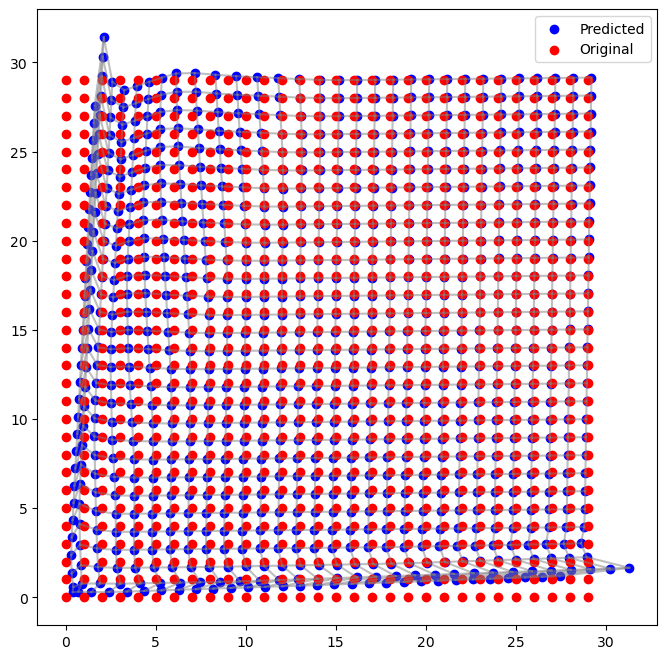

In [24]:
# Visualize the results
def visualize_cloth(data):
    plt.figure(figsize=(8, 8))
    out = model(data.x, data.edge_index).detach().numpy()
    plt.scatter(out[:, 0], out[:, 1], color='blue', label='Predicted')
    plt.scatter(data.x[:, 0], data.x[:, 1], color='red', label='Original')
    for i in range(data.edge_index.shape[1]):
        plt.plot(out[data.edge_index[:, i], 0], out[data.edge_index[:, i], 1], color='gray', alpha=0.5)
    plt.legend()
    plt.show()

visualize_cloth(data)

In [27]:
plt.figure(figsize=(10, 6))
for key, value in loss.items():
    plt.plot(range(len(value)), value, label=key)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()


AttributeError: 'Tensor' object has no attribute 'items'

<Figure size 1000x600 with 0 Axes>

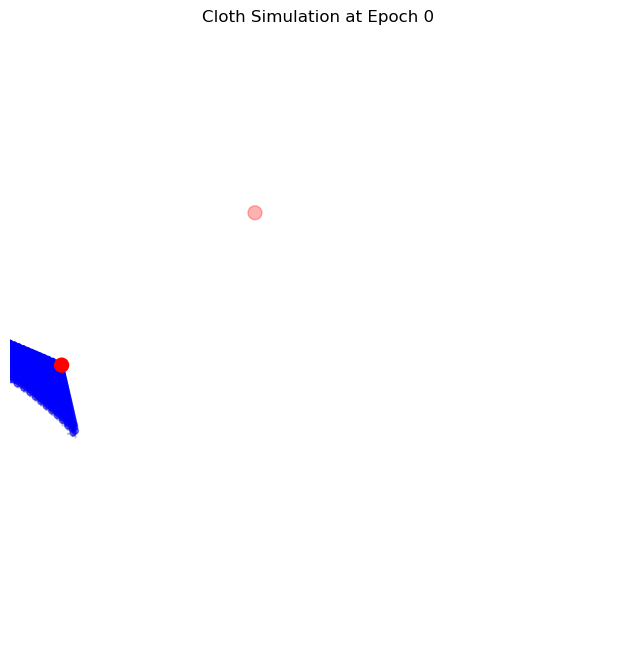

Epoch 0, Total Loss: 42.934547424316406, Collision Loss: 0.00928310863673687, Inertia Loss: 3.7556047681464033e-13, Gravity Loss: 42.40283966064453, Bending Loss: 0.5224226117134094, Wind Loss: 0.0
Epoch 10, Total Loss: 15.636102676391602, Collision Loss: 0.004304050002247095, Inertia Loss: 3.958381831505133e-17, Gravity Loss: 7.546900272369385, Bending Loss: 0.39182984828948975, Wind Loss: 7.693068981170654
Epoch 20, Total Loss: 15.393613815307617, Collision Loss: 0.0027121049351990223, Inertia Loss: 7.452886333110269e-20, Gravity Loss: 4.964705467224121, Bending Loss: 0.30447307229042053, Wind Loss: 10.121723175048828
Epoch 30, Total Loss: 6.63176965713501, Collision Loss: 0.002174399560317397, Inertia Loss: 7.107225985742382e-18, Gravity Loss: 1.5672085285186768, Bending Loss: 0.26970091462135315, Wind Loss: 4.7926859855651855
Epoch 40, Total Loss: 3.9738504886627197, Collision Loss: 0.0020097345113754272, Inertia Loss: 8.599731022631385e-19, Gravity Loss: 0.7318676710128784, Bendin

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import cv2

# Define the GNN Model
class ClothGNN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ClothGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Generate Cloth Data
def generate_cloth_data(num_points=30):
    points = np.array([[i, j, 0] for i in range(num_points) for j in range(num_points)], dtype=np.float32)
    edges = []
    for i in range(num_points):
        for j in range(num_points):
            if i < num_points - 1:
                edges.append([i * num_points + j, (i + 1) * num_points + j])
                edges.append([(i + 1) * num_points + j, i * num_points + j])
            if j < num_points - 1:
                edges.append([i * num_points + j, i * num_points + j + 1])
                edges.append([i * num_points + j + 1, i * num_points + j])
    edges = np.array(edges, dtype=np.int64).T
    return points, edges

points, edges = generate_cloth_data()
x = torch.tensor(points, dtype=torch.float)
edge_index = torch.tensor(edges, dtype=torch.long)
data = Data(x=x, edge_index=edge_index)

# Identify the indices of the fixed points (top-left and top-right corners)
fixed_points_indices = [0, 29]

# Initialize the model, optimizer, and loss function
model = ClothGNN(in_channels=3, out_channels=3)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define the new bending loss function
def bending_loss_edge_length(output, edge_index, initial_lengths):
    current_lengths = torch.norm(output[edge_index[0]] - output[edge_index[1]], dim=1)
    deviation = torch.abs(current_lengths - initial_lengths)
    loss = torch.sum(deviation)
    return loss / edge_index.size(1)

initial_lengths = torch.norm(x[edge_index[0]] - x[edge_index[1]], dim=1)

# Placeholder for other loss functions
def collision_loss(output, min_dist=1.0):
    dist = torch.cdist(output, output, p=2)
    loss = torch.clamp(min_dist - dist, min=0)
    return loss.mean()

def inertia_loss(output, prev_output, velocity, dt=0.1):
    velocity = (output - prev_output) / dt
    expected_pos = prev_output + velocity * dt
    return nn.MSELoss()(output, expected_pos)

def gravity_loss(output, gravity_strength=9.81):
    return gravity_strength * output[:, 1].mean()

# Wind force with alternating direction
def wind_force(output, wind_strength=0.1):
    wind_direction = torch.tensor([0.0, 1.0, 0.0], dtype=torch.float)
    return wind_strength * (output @ wind_direction).mean()


# Function to write OBJ files
def write_obj(filename, vertices, edges):
    with open(filename, 'w') as f:
        for vertex in vertices:
            f.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")
        for edge in edges.T:
            f.write(f"l {edge[0] + 1} {edge[1] + 1}\n")  # OBJ indices are 1-based

# Define the training function
prev_output = data.x.clone()
velocity = torch.zeros_like(data.x)

def train(data, fixed_points_indices, initial_lengths, epochs=100):
    global prev_output, velocity
    model.train()
    losses = {'total': [], 'collision': [], 'inertia': [], 'gravity': [], 'bending': [], 'wind': []}
    frames = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)

        # Keep the positions of fixed points constant
        out = out.clone()
        out[fixed_points_indices] = data.x[fixed_points_indices]

        # Compute losses
        coll_loss = collision_loss(out)
        inert_loss = inertia_loss(out, prev_output, velocity)
        grav_loss = gravity_loss(out)
        bend_loss = bending_loss_edge_length(out, data.edge_index, initial_lengths)
        wind_loss = wind_force(out, epoch)

        # Ensure all losses are positive
        coll_loss = torch.abs(coll_loss)
        inert_loss = torch.abs(inert_loss)
        grav_loss = torch.abs(grav_loss)
        bend_loss = torch.abs(bend_loss)
        wind_loss = torch.abs(wind_loss)

        # Aggregate all losses into a single scalar value
        loss = coll_loss + inert_loss + grav_loss + bend_loss + wind_loss

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update velocity and previous output
        velocity = out - prev_output
        prev_output = out.clone().detach()

        # Store losses
        losses['total'].append(loss.item())
        losses['collision'].append(coll_loss.item())
        losses['inertia'].append(inert_loss.item())
        losses['gravity'].append(grav_loss.item())
        losses['bending'].append(bend_loss.item())
        losses['wind'].append(wind_loss.item())

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss.item()}, Collision Loss: {coll_loss.item()}, Inertia Loss: {inert_loss.item()}, Gravity Loss: {grav_loss.item()}, Bending Loss: {bend_loss.item()}, Wind Loss: {wind_loss.item()}')

        # Store frames for the animation
        if epoch % 10 == 0:
            frame_path = f'frames/frame_{epoch:03d}.obj'
            visualize_cloth(data, model, epoch, fixed_points_indices, save=True, frame_path=frame_path)
            frames.append(frame_path)

    return losses, frames

# Function to visualize the cloth at each timestep
def visualize_cloth(data, model, epoch, fixed_points_indices, save=False, frame_path=None):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    out = model(data.x, data.edge_index).detach().numpy()
    
    # Plot cloth
    ax.scatter(out[:, 0], out[:, 1], out[:, 2], color='blue')
    for i in range(data.edge_index.shape[1]):
        start, end = out[data.edge_index[:, i]]
        ax.plot([start[0], end[0]], [start[1], end[1]], [start[2]], color='gray', alpha=0.5)
    
    # Ensure fixed points are plotted and not updated
    fixed_points = data.x[fixed_points_indices].detach().numpy()
    ax.scatter(fixed_points[:, 0], fixed_points[:, 1], fixed_points[:, 2], color='red', s=100)
    
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 30)
    ax.set_zlim(-15, 15)
    ax.set_title(f"Cloth Simulation at Epoch {epoch}")
    ax.set_axis_off()

    # Save the frame if required
    if save and frame_path is not None:
        os.makedirs('frames', exist_ok=True)
        vertices = out
        edges = data.edge_index
        write_obj(frame_path, vertices, edges)
        plt.close(fig)
    else:
        plt.show()

# Visualize the initial state of the cloth
visualize_cloth(data, model, epoch=0, fixed_points_indices=fixed_points_indices, save=False)

# Train the model and get losses and frames for animation
losses, frames = train(data, fixed_points_indices, initial_lengths, epochs=100)



In [ ]:
# To define the parameter of the clyinder with  formula according to frictional force
# The code is not runnning properly 
# the cycinder is not able to see in the graph
#


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import cv2


In [23]:
# Define the GNN Model
class ClothGNN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ClothGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [24]:
# Generate Cloth Data Above CylindeR
def generate_cloth_data(num_points=30, cloth_initial_height=25):
    x_cloth, y_cloth = np.meshgrid(np.linspace(-7.5, 7.5, num_points), np.linspace(-7.5, 7.5, num_points))
    z_cloth = np.full((num_points, num_points), cloth_initial_height)
    points_cloth = np.vstack((x_cloth.flatten(), y_cloth.flatten(), z_cloth.flatten())).T

    edges = []
    for i in range(num_points):
        for j in range(num_points):
            if i < num_points - 1:
                edges.append([i * num_points + j, (i + 1) * num_points + j])
                edges.append([(i + 1) * num_points + j, i * num_points + j])
            if j < num_points - 1:
                edges.append([i * num_points + j, i * num_points + j + 1])
                edges.append([i * num_points + j + 1, i * num_points + j])
    edges = np.array(edges, dtype=np.int64).T

    return points_cloth, edges

# Cylinder parameters
cylinder_radius = 2.5
cylinder_height = 10.0
cloth_initial_height = 25.0  # Set cloth initially above the cylinder

points, edges = generate_cloth_data(cloth_initial_height=cloth_initial_height)
x = torch.tensor(points, dtype=torch.float)
edge_index = torch.tensor(edges, dtype=torch.long)
data = Data(x=x, edge_index=edge_index)

cylinder_center = torch.tensor([0.0, 0.0, cylinder_height / 2])  # Center of the cylinder
friction_coefficient = 0.5
angular_velocity = 0.1
dt = 0.1

In [25]:

# Function to handle cloth-cylinder interaction
# Function to handle cloth-cylinder interaction
def cylinder_collision_response(output, cylinder_center, cylinder_radius, friction_coefficient, angular_velocity, dt=0.1):
    d = torch.sqrt((output[:, 0] - cylinder_center[0]) ** 2 + (output[:, 1] - cylinder_center[1]) ** 2)
    inside_cylinder = d < cylinder_radius
    response_positions = output.clone()
    response_positions[inside_cylinder, 0] = cylinder_center[0] + (output[inside_cylinder, 0] - cylinder_center[0]) / d[inside_cylinder] * cylinder_radius
    response_positions[inside_cylinder, 1] = cylinder_center[1] + (output[inside_cylinder, 1] - cylinder_center[1]) / d[inside_cylinder] * cylinder_radius
    response_positions[inside_cylinder, 2] = torch.max(response_positions[inside_cylinder, 2], cylinder_center[2] + cylinder_height / 2)
    
    # Calculate tangential velocity of the cylinder
    v_cylinder = torch.zeros_like(output)
    v_cylinder[:, 0] = -cylinder_radius * angular_velocity * torch.sin(torch.tensor(angular_velocity * dt))
    v_cylinder[:, 1] = cylinder_radius * angular_velocity * torch.cos(torch.tensor(angular_velocity * dt))

    # Calculate relative velocity and apply friction force
    v_vertex = (response_positions - output) / dt
    v_rel = v_vertex - v_cylinder
    friction_force = -friction_coefficient * v_rel * dt
    response_positions[inside_cylinder] += friction_force[inside_cylinder]
    
    return response_positions


In [26]:
# Function to visualize the cloth at each timestep
# Function to visualize the cloth at each timestep
def visualize_cloth(data, model, epoch, cylinder_center, cylinder_radius, save=False):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    out = model(data.x, data.edge_index).detach().numpy()
    ax.scatter(out[:, 0], out[:, 1], out[:, 2], color='blue')
    for i in range(data.edge_index.shape[1]):
        start, end = out[data.edge_index[:, i]]
        ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], color='gray', alpha=0.5)
    
    # Plot the cylinder
    u = np.linspace(0, 2 * np.pi, 100)
    z = np.linspace(0, cylinder_height, 100)
    U, Z = np.meshgrid(u, z)
    X = cylinder_center[0].item() + cylinder_radius * np.cos(U)
    Y = cylinder_center[1].item() + cylinder_radius * np.sin(U)
    Z = cylinder_center[2].item() + Z
    ax.plot_surface(X, Y, Z, alpha=0.2, color='r')

    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.set_zlim(0, 40)
    ax.set_title(f"Cloth Simulation at Epoch {epoch}")
    ax.set_axis_off()

    # Save the frame if required
    if save:
        os.makedirs('frames', exist_ok=True)
        frame_path = f'frames/frame_{epoch:03d}.png'
        plt.savefig(frame_path)
        plt.close(fig)
        return frame_path
    else:
        plt.show()

# Create animation
def create_animation(frame_folder='frames', output_file='animation.mp4'):
    frame_files = sorted([f for f in os.listdir(frame_folder) if f.endswith('.png')])
    frame_files = [os.path.join(frame_folder, f) for f in frame_files]
    frame = cv2.imread(frame_files[0])
    height, width, layers = frame.shape
    video = cv2.VideoWriter(output_file, cv2.VideoWriter_fourcc(*'mp4v'), 1, (width, height))  # 1 frame per second
    for frame_file in frame_files:
        video.write(cv2.imread(frame_file))
    cv2.destroyAllWindows()
    video.release()

# Initialize the model, optimizer, and loss function
model = ClothGNN(in_channels=3, out_channels=3)
optimizer = optim.Adam(model.parameters(), lr=0.01)



In [27]:
# Define the new bending loss function
def bending_loss_edge_length(output, edge_index, initial_lengths):
    current_lengths = torch.norm(output[edge_index[0]] - output[edge_index[1]], dim=1)
    deviation = torch.abs(current_lengths - initial_lengths)
    loss = torch.sum(deviation)
    return loss / edge_index.size(1)

initial_lengths = torch.norm(x[edge_index[0]] - x[edge_index[1]], dim=1)


# Placeholder for other loss functions
def collision_loss(output, min_dist=1.0):
    dist = torch.cdist(output, output, p=2)
    loss = torch.clamp(min_dist - dist, min=0)
    return loss.mean()

def inertia_loss(output, prev_output, velocity, dt=0.1):
    velocity = (output - prev_output) / dt
    expected_pos = prev_output + velocity * dt
    return nn.MSELoss()(output, expected_pos)

def gravity_loss(output, gravity_strength=9.81):
    return gravity_strength * output[:, 2].mean()

# Define the training function
prev_output = data.x.clone()
velocity = torch.zeros_like(data.x)

def train(data, fixed_points_indices, initial_lengths, start_epoch=0, num_epochs=10):
    global prev_output, velocity
    model.train()
    frames = []
    for epoch in range(start_epoch, start_epoch + num_epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)

        # Keep the positions of fixed points constant
        out = out.clone()
        out[fixed_points_indices] = data.x[fixed_points_indices]

        # Apply cylinder collision response
        out = cylinder_collision_response(out, cylinder_center, cylinder_radius, friction_coefficient, angular_velocity)

        # Compute losses
        coll_loss = collision_loss(out)
        inert_loss = inertia_loss(out, prev_output, velocity)
        grav_loss = gravity_loss(out)
        bend_loss = bending_loss_edge_length(out, data.edge_index, initial_lengths)
        
        # Ensure all losses are positive
        coll_loss = torch.abs(coll_loss)
        inert_loss = torch.abs(inert_loss)
        grav_loss = torch.abs(grav_loss)
        bend_loss = torch.abs(bend_loss)
        
        # Aggregate all losses into a single scalar value
        loss = coll_loss + inert_loss + grav_loss + bend_loss
        
        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update velocity and previous output
        velocity = out - prev_output
        prev_output = out.clone().detach()

        # Save the frame
        frame_path = visualize_cloth(data, model, epoch, cylinder_center, cylinder_radius, save=True)
        frames.append(frame_path)

        print(f"Epoch {epoch+1}/{start_epoch + num_epochs}, Loss: {loss.item()}")

    return frames

# Run the training and generate frames
total_epochs = 10
batch_size = 10
fixed_points_indices = np.arange(0, 30)  # Top row points of the cloth
frames = []
for i in range(0, total_epochs, batch_size):
    frames.extend(train(data, fixed_points_indices, initial_lengths, start_epoch=i, num_epochs=batch_size))

# Create the animation
create_animation(frame_folder='frames', output_file='cloth_cylinder_interaction 1.mp4')

Epoch 1/10, Loss: 11.14413833618164
Epoch 2/10, Loss: 4.931800842285156
Epoch 3/10, Loss: 8.222756385803223
Epoch 4/10, Loss: 9.953259468078613
Epoch 5/10, Loss: 8.459123611450195
Epoch 6/10, Loss: 4.7382588386535645
Epoch 7/10, Loss: 1.9766114950180054
Epoch 8/10, Loss: 2.5162034034729004
Epoch 9/10, Loss: 2.185361862182617
Epoch 10/10, Loss: 2.070700168609619
